# Lake Hume 11DEC18 Landsat 8 overpass workflow

### General setup

In [1]:
import time, sys, os, shutil
start_time = time.time()

from datetime import datetime, timedelta

import pandas as pd
import numpy as np

sys.path.append("..")
from CalVal import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300


field_data = ['HUM', '11DEC18', '', 'Landsat8', '', '', '']
indir='/g/data/u46/users/aw3463/GuyByrne/30APR18/Lake_Hume/11DEC18/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/HUM-11DEC18-LS8-20PC/'
fignum=1

directory = os.path.dirname(output)
if os.path.exists(directory):
    shutil.rmtree(directory)
os.makedirs(directory)

    
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 1.0, 0.0, 0.0],
                          ['band11', 1.0, 0.0, 0.0],
                          ['band12', 1.0, 0.0, 0.0],
                          ['band2', 1.0, 0.0, 0.0],
                          ['band3', 1.0, 0.0, 0.0],
                          ['band4', 1.0, 0.0, 0.0],
                          ['band5', 1.0, 0.0, 0.0],
                          ['band6', 1.0, 0.0, 0.0],
                          ['band7', 1.0, 0.0, 0.0],
                          ['band8', 1.0, 0.0, 0.0],
                          ['band8a', 1.0, 0.0, 0.0],
                         ])
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'

## IMPORTANT NOTE
Original csv file has three spreadsheets with incorrect labels. 
The following is the mapping from original labels to the currently used labels in this workflow.<P>

<TABLE>
<TR>

<TD>Original Label</TD><TD>Device ID</TD><TD>Device Description</TD><TD>Name Used in this Workflow</TD></TR>
<TR><TD>ed</TD><TD>8494</TD><TD>Scalar Irradiance - spherical</TD><TD>Lu</TD></TR>
<TR><TD>ed Total</TD><TD>8035</TD><TD>Irradiance - cosine</TD><TD>Ed</TD></TR>
<TR><TD>lu</TD><TD>81f7</TD><TD>Radiance - 7$^\circ$ FOV</TD><TD>Lsky</TD></TR>
</TABLE>



### Read in Lu, set Wavelength to be index and drop bad spectra

In [2]:
Lu = pd.read_csv(indir+'Hume_8494.csv')
Lu.set_index('Time', inplace=True)
Lu.index.names = ['Wavelength']
Lu.drop('592.53333', axis=1, inplace=True)

### Plot Lu spectra

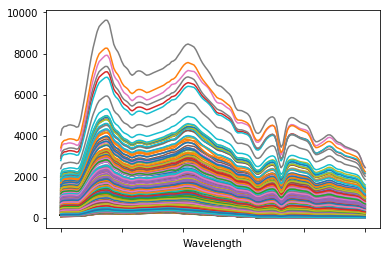

In [3]:
Lu.iloc[1:].astype(float).plot(legend=False)
plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_FIG'+str(fignum)+'_Lu.png')
fignum+=1

### Read in Ed and set Wavelength as index

In [4]:
Ed = pd.read_csv(indir+'Hume_8035.csv')
Ed.set_index('Time', inplace=True)
Ed.index.names = ['Wavelength']

### Plot Ed

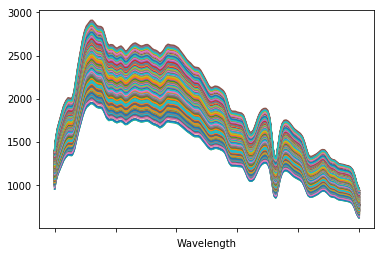

In [5]:
Ed.iloc[1:].astype(float).plot(legend=False)

### Remove any spectra from Ed where the first channel is NOT between 400-600
### Plot the result

In [6]:
#badcols = []
#
#for i in range(len(Ed.iloc[0])):
#    if Ed.iloc[0,i]>600 or Ed.iloc[0,i]<400:
#        badcols.append(i)
#        
#Ed.drop(Ed.columns[badcols], axis=1, inplace=True)
#
#Ed.plot(legend=False)
#plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_FIG'+str(fignum)+'_Ed.png')
#fignum+=1

### Read in Lsky and set index to Wavelength

In [7]:
Lsky = pd.read_csv(indir+'Hume_81f7.csv')
Lsky.set_index('Time', inplace=True)
Lsky.index.names = ['Wavelength']

### Remove bad spectra from Lsky (anything where first channel is below 200)
### Plot the result

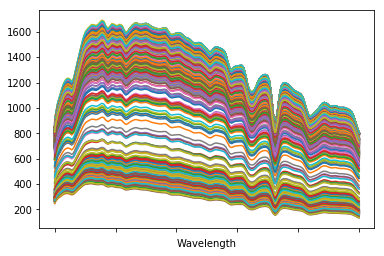

In [8]:
badcols = []

for i in range(len(Lsky.iloc[1])):
    if float(Lsky.iloc[1,i])<200:
        badcols.append(i)
        
Lsky.drop(Lsky.columns[badcols], axis=1, inplace=True)

Lsky.iloc[1:].astype(float).plot(legend=False)
plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_FIG'+str(fignum)+'_Lsky.png')
fignum+=1

### Convert times for columns to seconds

In [9]:
res_Lu = [int(60*x) for x in Lu.columns.values.astype(float)]
res_Ed = [int(60*x) for x in Ed.columns.values.astype(float)]
res_Lsky = [int(60*x) for x in Lsky.columns.values.astype(float)]

### Relabel column names to time in seconds (since midnight)

In [10]:
Ed.columns = res_Ed
Lsky.columns = res_Lsky
Lu.columns = res_Lu

In [11]:
#
# Create new DataFrame (ednew) that has Ed spectra, with columns matched to within 2 seconds of
# a corresponding Lu spectrum. This means we can now loop through ednew spectra to combine
# with Lu spectra.
#
ednew = pd.DataFrame()

for j in range(len(res_Lu)):
    lus = []
    for i in res_Ed:
        lus.append(abs(res_Lu[j]-i))
    if min(lus)<2:
        ednew[res_Lu[j]] = Ed[Ed.columns[lus.index(min(lus))]]

In [12]:
lskynew = pd.DataFrame()

for j in range(len(res_Lu)):
    lus = []
    for i in res_Lsky:
        lus.append(abs(res_Lu[j]-i))
    if min(lus)<2:
        lskynew[res_Lu[j]] = Lsky[Lsky.columns[lus.index(min(lus))]]
    else:
        Lu.drop(res_Lu[j], axis=1, inplace=True)
        try:
            ednew.drop(res_Lu[j], axis=1, inplace=True)
            print('No Lsky available for', res_Lu[j], '- Dropping from Lu and Ed')
        except KeyError:
            print('No Lsky available for', res_Lu[j], '- Dropping from Lu only')

No Lsky available for 36912 - Dropping from Lu and Ed
No Lsky available for 36915 - Dropping from Lu and Ed
No Lsky available for 36918 - Dropping from Lu and Ed
No Lsky available for 36919 - Dropping from Lu and Ed
No Lsky available for 36922 - Dropping from Lu and Ed
No Lsky available for 36924 - Dropping from Lu only
No Lsky available for 36925 - Dropping from Lu only
No Lsky available for 36928 - Dropping from Lu only
No Lsky available for 36930 - Dropping from Lu only
No Lsky available for 36931 - Dropping from Lu only
No Lsky available for 36934 - Dropping from Lu only
No Lsky available for 36936 - Dropping from Lu only
No Lsky available for 36937 - Dropping from Lu only
No Lsky available for 36940 - Dropping from Lu only
No Lsky available for 36942 - Dropping from Lu only
No Lsky available for 36943 - Dropping from Lu only
No Lsky available for 36946 - Dropping from Lu only
No Lsky available for 36948 - Dropping from Lu only
No Lsky available for 36949 - Dropping from Lu only
No

### Define refl_df - DataFrame with reflectances

Formula used to create refl_df is <P>
    $\pi \times (L_u - \rho \times L_{sky})/E_d$<P>
    
with $\rho=0$, such that Lsky is not needed.<BR>
Due to the potential mimatch in timestamps (of up to 1 second) between spectra,
the following method is used to re-align spectra in time:<BR>
First see if times align, <BR>if not, see if there is Lu spectrum 1 second before Ed spectrum.<BR>
If not, see if there is Lu spectrum 1 second after Ed spectrum.</P>

This should align all spectra.

In [13]:
### Use this cell for (Lu - rho*Lsky)/Ed, (with rho=0)

Rho = 0.0#256

refl_df = pd.DataFrame()

for i in ednew.columns.values:
    refl_df[i] = (Lu.iloc[1:][i].astype(float) - (Rho * lskynew.iloc[1:][i].astype(float))) / (np.pi * ednew.iloc[1:][i].astype(float))

In [14]:
refl_df.index = refl_df.index.map(int)

### Extend ends of spectra (at 400 and 900nm) out to 350-2500nm.
This allows matching with satellite bands to behave nicely.<BR>
But note that there is no real data outside 400-900nm.

In [15]:
for i in range(901, 2501):
    refl_df.loc[i] = refl_df.loc[900]
for i in range(350, 399):
    refl_df.loc[i] = refl_df.loc[400]

### Define median of all reflectances and plot

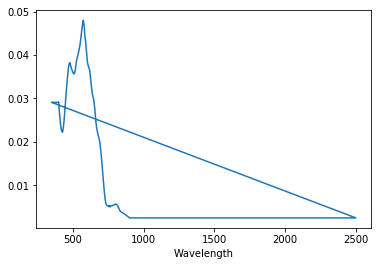

In [16]:
median = refl_df.median(axis=1)
median.plot()

### Apply satellite band weights
Convole the spectra into the satellite bands and produce both Landsat and Sentinel band DataFrames

In [17]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, refl_df, sat_resp, field_data)

### Add columns to dataframes
Manually add latitude, longitude and timestamp to Landsat and Sentinel DataFrames

In [18]:
ls_result_df['Latitude'] = -36.116907
ls_result_df['Longitude'] = 147.026011
ls_result_df['Line'] = ednew.loc['Comment'].values
ls_result_df['date_saved'] = datetime(2018, 12, 10, 23, 48, 40)

s2_result_df['Latitude'] = -36.116907 
s2_result_df['Longitude'] = 147.026011
s2_result_df['Line'] = ednew.loc['Comment'].values
s2_result_df['date_saved'] = datetime(2018, 12, 10, 23, 48, 40)

### Based on relative time shift found in ednew, adjust the timestamps to reflect the real UT when spectrum was recorded.

In [19]:
#
# First spectrum for all data is at t=35320 seconds, so subtract that off.
#
ls_result_df['TDelt'] = ednew.columns-35320

# Convert seconds offset to a timedelta
ls_result_df.TDelt = pd.to_timedelta(ls_result_df.TDelt, unit='s')

# Apply seconds offset to DataFrame
ls_result_df.date_saved = ls_result_df.date_saved+ls_result_df.TDelt

# Remove extra column in DataFrame, since it is no longer needed.
ls_result_df.drop(columns='TDelt', inplace=True)

# REPEAT FOR Sentinel 2 DataFrame
s2_result_df['TDelt'] = ednew.columns-35320
s2_result_df.TDelt = pd.to_timedelta(s2_result_df.TDelt, unit='s')
s2_result_df.date_saved = s2_result_df.date_saved+s2_result_df.TDelt
s2_result_df.drop(columns='TDelt', inplace=True)

### Read in GPS data
Based on the file "LH_gps.csv", which lists start and end coordinates for each Line, interpolate GPS coordinates to the data. For any spectrum, this updates the coordinates with all GPS entries

In [20]:
gps_data = pd.read_csv(indir+'LH_gps.csv')
gps_data.set_index('Line', inplace=True)

In [21]:
LineNames = ['WE', 'EW', 'SN1', 'SN2', 'SN3', 'SN4', 'SN5', 'SN6', 'SN7', 'SN8']

d={}

for i in LineNames:
    d["LatDelt{0}".format(i)] = (gps_data.loc[i].Elat - gps_data.loc[i].Slat) / \
                (len(ls_result_df[ls_result_df.Line==i])-1)
    d["LonDelt{0}".format(i)] = (gps_data.loc[i].Elon - gps_data.loc[i].Slon) / \
                (len(ls_result_df[ls_result_df.Line==i])-1)
    
    LineIndex = ls_result_df.loc[ls_result_df.Line==i, 'Latitude'].index[0]
    for j in range(len(ls_result_df[ls_result_df.Line==i])):
        ls_result_df.loc[LineIndex+j, 'Latitude'] = gps_data.loc[i].Slat + (d["LatDelt{0}".format(i)] * j)
        ls_result_df.loc[LineIndex+j, 'Longitude'] = gps_data.loc[i].Slon + (d["LonDelt{0}".format(i)] * j)
        s2_result_df.loc[LineIndex+j, 'Latitude'] = gps_data.loc[i].Slat + (d["LatDelt{0}".format(i)] * j)
        s2_result_df.loc[LineIndex+j, 'Longitude'] = gps_data.loc[i].Slon + (d["LonDelt{0}".format(i)] * j)


### Add column to dataframes that lists the Solar zenith angle, based on lat, long and time.

In [22]:
from CalVal.SolarAngle import solang
ls_result_df['Solar_angle'] = ls_result_df.apply(solang, axis=1)
s2_result_df['Solar_angle'] = s2_result_df.apply(solang, axis=1)

### Determine BRDF parameters
This should not be needed over a marine environment, but is included in case of compatibility in the future.

In [23]:
PrintBRDF.print_brdf(ls_result_df, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-12-10 23:48:40'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(147.02600900000002, -36.12085, 147.045068, -36.11188)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Apply BRDF corrections
At the moment, the BRDF parameters are set so that no correction is applied.<BR>
This is kept in for possible future compatibility.

In [24]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_result_df, s2_result_df, field_data)

### Determine wavelength extents of satellite bands

In [25]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

### Plot median spectrum, with band wavelength ranges
Note: Only bands 1-7 (Sentinel) are relevant because the ramses only collects between 400-900 nm.

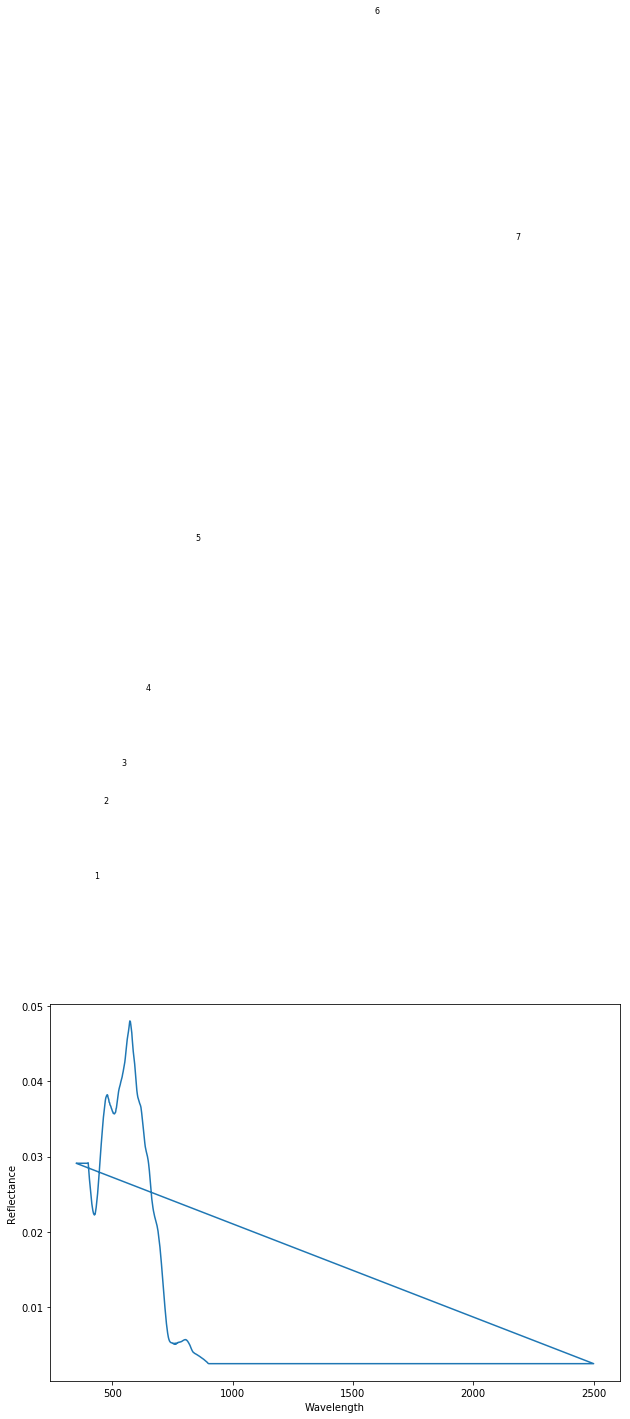

In [26]:
FIG_BandExtents.FIG_band_extents(refl_df, band_min, band_max, output, field_data, fignum)
fignum += 1

In [27]:
ls_ground_brdf = ls_ground_brdf[ls_ground_brdf.band1 < ls_ground_brdf.band1.quantile(0.2)]
s2_ground_brdf = s2_ground_brdf[s2_ground_brdf.band1 < s2_ground_brdf.band1.quantile(0.2)]

### Retrieve satellite data from Datacube

In [28]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_ground_brdf, s2_ground_brdf, ls_result_df, s2_result_df, field_data, Corners, RockWalk, StartCorner)

Assuming good GPS Coordinates, continuing...


### Location comparison of field and satellite data
Field data locations are shown as coloured dots.<BR>
Satellite pixels are shown as the squares, with the centre of each pixel shown by a black dot.

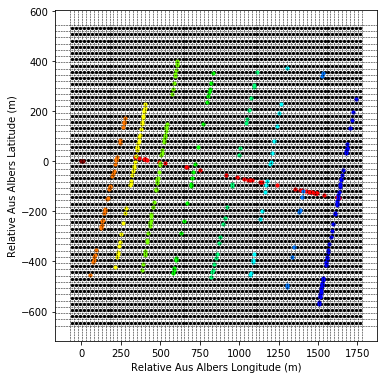

In [29]:
ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, output, field_data, fignum)
fignum +=1

### Create field data array, based on satellite pixels
Use the satellite pixel locations to create an array with the same locations for each pixel.<BR>
The values in each pixel are the average value of field data that overlap in position with that pixel.<BR>
If there are no overlapping field data points, then the pixel remains blank.<BR>

In [30]:
ls_field_array, s2_field_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)
ls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)

### Plot large-area RGB image of satellite data
Used to assess the context for the field site. This plot is approximately 2 km on each side 
(technically 0.02$^\circ$). The B/W square in the middle represents the location of the field
site. But note that the field site may be oriented at an angle to North, which is not represented here.

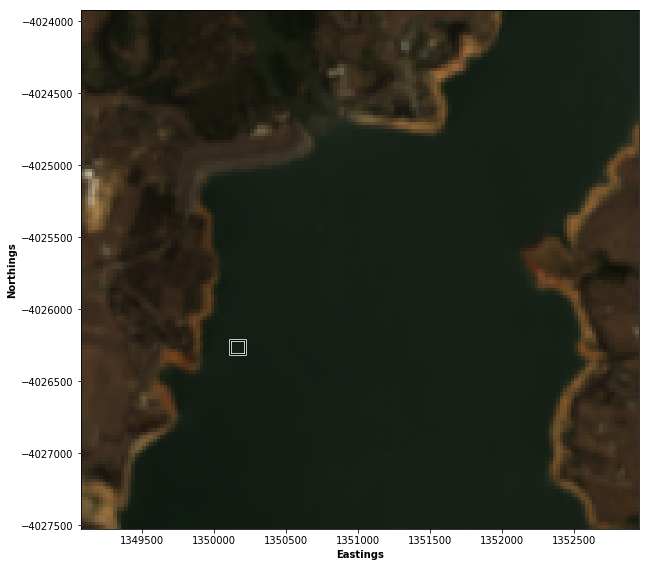

In [31]:
if field_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(ls_sat_array, ls_sat_bigarray, output, field_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(s2_sat_array, s2_sat_bigarray, output, field_data, fignum)
fignum += 1

### Plot satellite RGB image
This RGB image contains only the satellite pixels corresponding to the field site area, plus a buffer of typically 1-2 pixels.

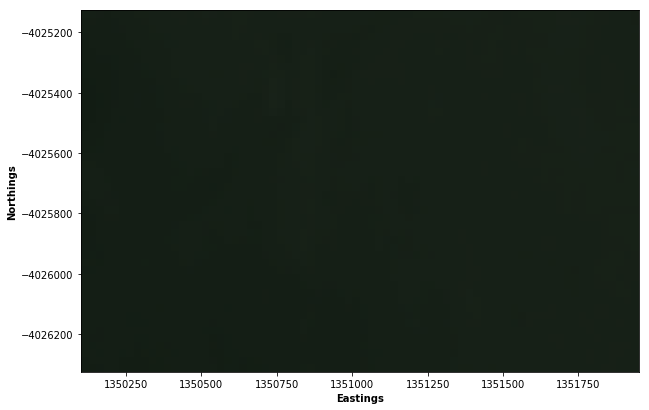

In [32]:
if field_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(ls_sat_array, output, field_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(s2_sat_array, output, field_data, fignum)
fignum += 1

### Field date RGB image
This plot shows the RGB image for the field data pixels. Blank pixel (where there is not field data) are shown as black.
The pixels correspond exactly to the previous image.

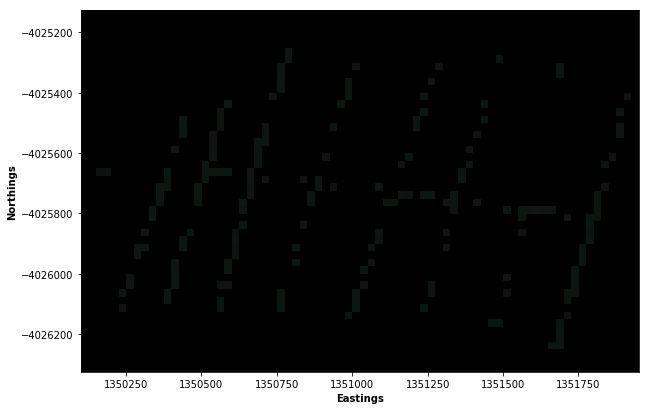

In [33]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_array, output, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_array, output, field_data, fignum)
fignum += 1

### Plot of location stability of field site
Satellite data over the field site are plotted for each band. 
Data in each band have been normalised to the average value for that band, 
so relative intensities are shown. 
A perfectly flat field site will show a uniform green colour, corresponding to 1.0 intensity scale.
A non-uniform field site will show more yellows and blues.

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/_collections_abc.py:761: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


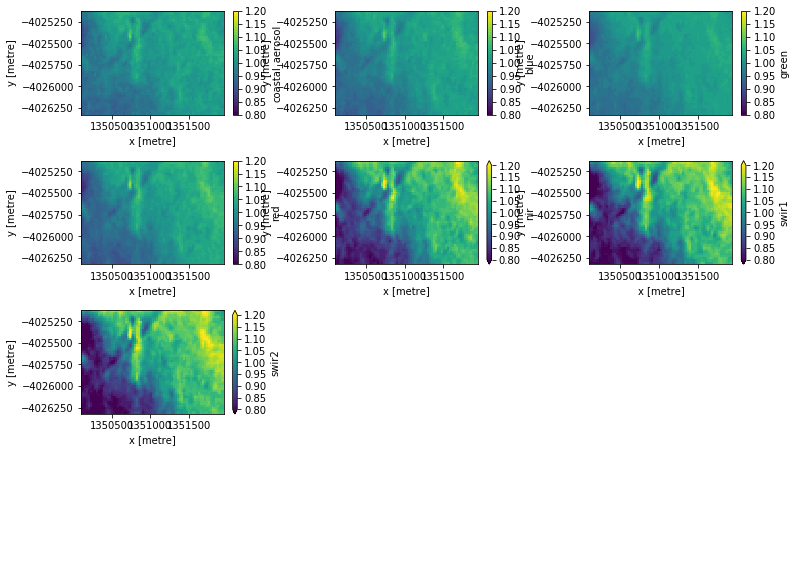

In [34]:
if field_data[3] == 'Landsat8':
    variance = FIG_SatBands.FIG_sat_bands(ls_sat_array, ls_field_array, output, field_data, fignum)
else:
    variance = FIG_SatBands.FIG_sat_bands(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

### Ratio plot of field/satellite pixels
For the overlapping pixels between field and satellite data, how the ratio, 
such that a perfect agreement between field and satellite will show a green colour, with intensity 1.0.

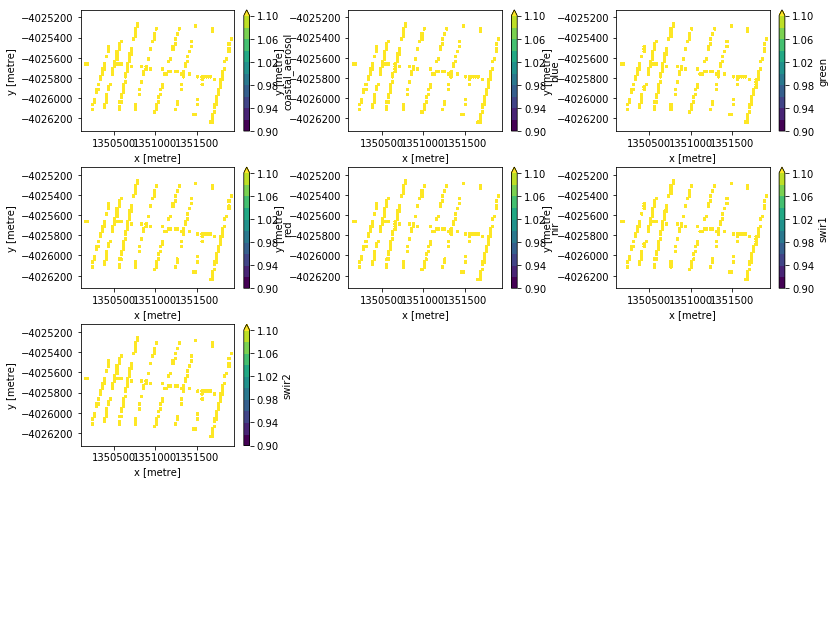

In [35]:
if field_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(ls_sat_array, ls_field_array, output, field_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

### Create statistic summary DataFrames

In [36]:
ls_fstat_df, s2_fstat_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
ls_fstat_WSdf, dummy = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

if field_data[6] == 'USGS':
    ls_fstat_usgs_df, dummy = CreateStats.create_stats(ls8_usgs_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
else:
    ls_fstat_usgs_df = 0

### Create statistic sunmmary DataFrames, using only those pixels overlapping with field data locations

In [37]:
ls_finner_df, s2_finner_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_array, s2_field_array, ls_ground_brdf, s2_ground_brdf, ls_fstat_df, s2_fstat_df, field_data)
ls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_WSarray, s2_field_array, ls_ground_WSbrdf, s2_ground_brdf, ls_fstat_WSdf, s2_fstat_df, field_data)

### Plot band spectra
This plot compares band spectra for both field and satellite data.<BR>
Field data average is shown in blue. Satellite averages are shown in black and orange.<BR>
The difference between black and orange satellite lines is that the black line includes all the
satellite pixels over the field site, plus any buffer pixels. The orange line includes only those 
satellite pixels that overlap with at least one field spectrum location.

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


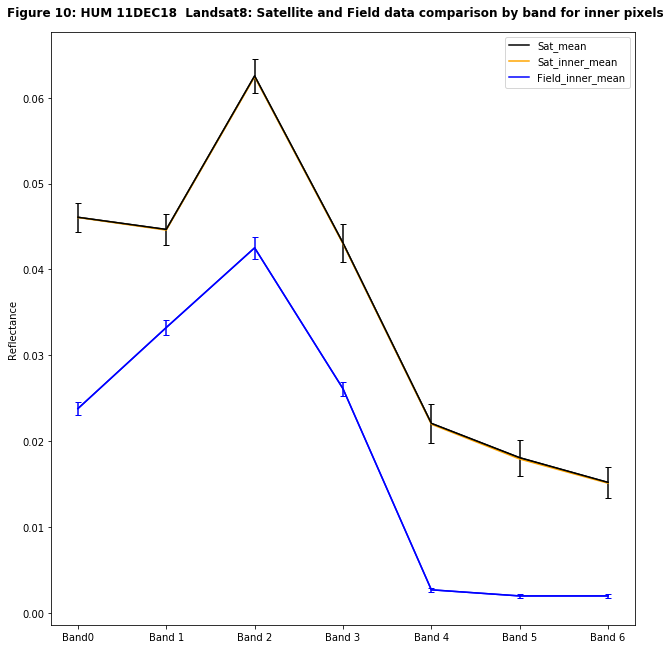

In [38]:
if field_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls_sat_array, ls_fstat_df, ls_finner_df, output, field_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

### Printable version of previous plot
Only the satellite data that includes all pixels over the field site (plus buffer) is shown in blue.
Field data shown in red.

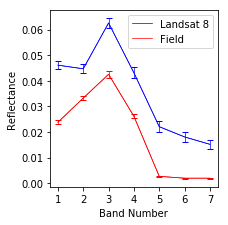

In [39]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(ls_sat_array, ls_fstat_df, ls_finner_df, output, field_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

### Comparison plot of field and satellite data on pixel-by-pixel basis
Data from each band are shown with different colours and different symbols.
The diagonal line represents equality between field and satellite points, so that ideally all points
should lie along this line.

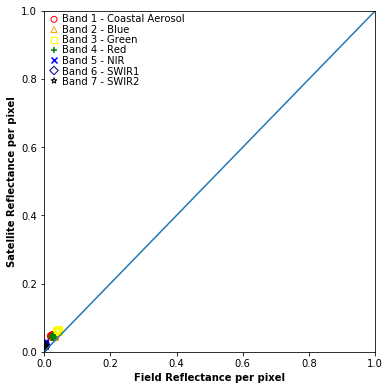

In [40]:
plot_scale = [0.0, 1.0, 0.0, 1.0]
if field_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ls_sat_array, ls_field_array, plot_scale, output, field_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(s2_sat_array, s2_field_array, plot_scale, output, field_data, fignum)
fignum += 1

### Plot average comparison of field and satellite data
Error bars are 1$\sigma$ uncertainties, based on the pixel-by-pixel variability.

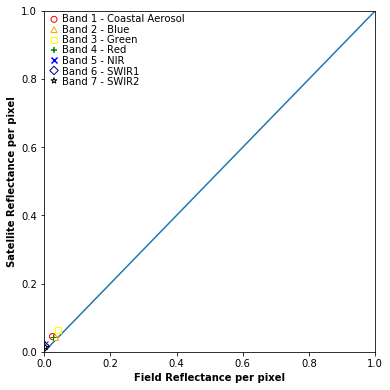

In [41]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ls_sat_array, ls_field_array, plot_scale, ls_fstat_df, output, field_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(s2_sat_array, s2_field_array, plot_scale, s2_fstat_df, output, field_data, fignum)
fignum += 1

### Print out data summary sheet

In [42]:
indir = ''
if field_data[3] == 'Landsat8':
    PrintSheet.print_sheet(ls_ground_brdf, ls_sat_array, ls_fstat_df, indir, output, field_data, Corners, RockWalk, StartCorner, variance, ls_query, ls_dc)
else:
    PrintSheet.print_sheet(s2_ground_brdf, s2_sat_array, s2_fstat_df, indir, output, field_data, Corners, RockWalk, StartCorner, variance, s2_query, s2_dc)

### Write out csv files with summary comparison data

In [43]:
OutputCSVs.output_csvs(ls_fstat_df, ls_fstat_usgs_df, s2_fstat_df, ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)

Difference in time between field site measurement and LS8 data is 0 days 00:14:05


In [44]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  4:35:09 (h:m:s) to run


In [45]:
from datacube.helpers import ga_pq_fuser, write_geotiff

#set dataset equal to landsat dataset
ds = j_lsarray
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        #drop the time dimension for only one timestep
        #write the dataset without the data percentage to file
        try:
            ds1 = ds.squeeze()
            #ds1 = ds1.drop('data_perc')
            write_geotiff('blah2.tif', ds1)
            #complain if the file already exists but don't fail
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

elif len(ds.time)>1:
    print('multiple timesteps')
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_LS_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

NameError: name 'j_lsarray' is not defined

In [ ]:
dc=datacube.Datacube()

jquery = {
             'time': ('2018-12-10', '2018-12-12'),
             'lat': (-36.24, -36.1),
             'lon': (146.98, 147.18),
             'output_crs': 'EPSG:3577',
             'resampling': 'bilinear',
             'group_by': 'solar_day'
            }

lb_names = ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']

jquery['resolution'] = (-25, 25)
j_lsarray = dc.load(product='ls8_nbart_scene', **jquery)


In [ ]:
j_lsarray

In [ ]:
ls_ground_brdf